In [1]:
import numpy as np
import matplotlib.pyplot as plt

We consider a gas composed of neutral identical particles that interact between each other by the Lennard-Jones potential

$$V_{ij} = 4 \epsilon \left[\left( \frac{\sigma}{r_{ij}} \right)^{12} - \left( \frac{\sigma}{r_{ij}} \right)^{6} \right]$$

which led to a force on the ith particle of
$$ \vec{F}_{i} = 24\epsilon \sum\limits_{j=1}^{N} \left[\frac{2\,\sigma^{12}}{r_{ij}^{13}}-\frac{\sigma^6}{r_{ij}^7}  \right] \hat{r}_{ij}$$ 

where $\vec{r}_{ij}=\vec{r}_i-\vec{r}_j$


For implementing this equations into code we define the next variables
$$\bar{t}=\sqrt{\frac{24\epsilon}{m\sigma}}t\,,$$
$$ \vec{r}' = \frac{\vec{r}}{\sigma}\,,$$
$$ \bar{r}_{ij} =\frac{r_{ij}}{\sigma}\,. $$

With this definitions we have
$$ \frac{d^2\vec{r}'_{i}}{d \bar{t}^2}=\sum\limits_{j=1}^{N}\left(\frac{2}{\bar{r}_{ij}^{13}}-\frac{1}{\bar{r}_{ij}^7} \right) \hat{r}'_{ij}$$ 

In [262]:
class LJGas:
    def __init__(self,h=0.05,N=100,Np=2,R0=1.05,h0=0.01):
        # Dynamic parameters
        self.h = h  # Time lapse between steps
        self.N = N   # Number of steps
        self.Np = Np    # Number of particles

        self.h1 = self.h

        # Control parameters
        self.R0 = R0                        # Distance of contact
        self.F0 = 2/self.R0**13-1/self.R0**7  # Force of contact
        self.h0 = h0   # Time step for contact events

    def get_self(self):
        return self

    # Functions
    def Fk(self,X,Y,Vx,Vy):
        # Associated matrixes of distance and force
        I = np.eye(self.Np)
        A, B = np.meshgrid(X,X); dX = A-B
        A, B = np.meshgrid(Y,Y); dY = A-B 
        R = np.sqrt(dX**2+dY**2) + I
        F = 2/R**13-1/R**7
        Ax1 = F*dX/R
        Ay1 = F*dY/R

        # Flatten vectors
        Ax = np.sum(Ax1,axis=0)
        Ay = np.sum(Ay1,axis=0)
        return np.array([Vx, Vy, Ax, Ay])

    def simulate(self,CI):
        LX = np.zeros((self.N+1,self.Np))
        LY = np.zeros((self.N+1,self.Np))
        LVx = np.zeros((self.N+1,self.Np))
        LVy = np.zeros((self.N+1,self.Np))
        self.Lh = np.zeros(self.N+1)

        LX[0] = CI[0]
        LY[0] = CI[1]
        LVx[0] = CI[2]
        LVy[0] = CI[3]
        self.Lh[0] = self.h

        self.aux = 0

        for i in range(self.N):
            next_val, F1 = self.next_value(LX[i],LY[i],LVx[i],LVy[i])
            LX[i+1] = next_val[0]
            LY[i+1] = next_val[1]
            LVx[i+1] = next_val[2]
            LVy[i+1] = next_val[3]
            
            if np.max(F1) >= self.F0: 
                self.h = self.h0
                self.aux = 1
                print('here',i,self.h)
            else: 
                self.h = self.h1
                if self.aux ==1: 
                    print('here',i,self.h)
                    self.aux = 2
            self.Lh[i+1] = self.h

        return [LX, LY, LVx, LVy]

    def next_value(self,X,Y,Vx,Vy):
        """
            Calculates the next positions and velocities after a time lapse of self.h
            Find the 4 k-values of the Runge-Kutta method (RK4)
            @params
            X,Y,Vx,Vy:
                np.array of the position and velocity of the particles

            @returns
            xf,yf,vxf,vyf
                np.array that contains the final positions and velocities of the particles
        """
        #K1 and calculations
        K1 = self.h*self.Fk(X,Y,Vx,Vy)
        X1 = X + K1[0]/2
        Y1 = Y + K1[1]/2
        Vx1 = Vx + K1[2]/2
        Vy1 = Vy + K1[3]/2

        F1 = np.sqrt(K1[2]**2+K1[3]**2)/self.h #net force

        #K2 and calculations
        K2 = self.h*self.Fk(X1,Y1,Vx1,Vy1)
        X2 = X + K2[0]/2
        Y2 = Y + K2[1]/2
        Vx2 = Vx + K2[2]/2
        Vy2 = Vy + K2[3]/2

        #K3 and calculations
        K3 = self.h*self.Fk(X2,Y2,Vx2,Vy2)
        X3 = X + K3[0]
        Y3 = Y + K3[1]
        Vx3 = Vx + K3[2]
        Vy3 = Vy + K3[3]

        #K4 and calculating final positions
        K4 = self.h*self.Fk(X3,Y3,Vx3,Vy3)
        Xf = X + 1/6*(K1[0] + 2*K2[0] + 2*K3[0] + K4[0])
        Yf = Y + 1/6*(K1[1] + 2*K2[1] + 2*K3[1] + K4[1])
        Vxf = Vx + 1/6*(K1[2] + 2*K2[2] + 2*K3[2] + K4[2])
        Vyf = Vy + 1/6*(K1[3] + 2*K2[3] + 2*K3[3] + K4[3])
        return np.array([Xf, Yf, Vxf, Vyf]), F1

    def get_net_force(self,s):
        X1 = s[0][:,0]; X2 = s[0][:,1]
        Y1 = s[1][:,0]; Y2 = s[1][:,1]
        R = np.sqrt((X1-X2)**2+(Y1-Y2)**2)
        F = 2/R**13-1/R**7
        return F

    def get_Energy(self,s):
        X1 = s[0][:,0]; X2 = s[0][:,1]
        Y1 = s[1][:,0]; Y2 = s[1][:,1]
        VX1 = s[2][:,0]; VX2 = s[2][:,1]
        VY1 = s[3][:,0]; VY2 = s[3][:,1]
        R = np.sqrt((X1-X2)**2+(Y1-Y2)**2)
        Ek = 1/2*(VX1**2+VY1**2+VX2**2+VY2**2)
        V = 1/(6*R**12)-1/(6*R**6)
        return [Ek,V,Ek+V]

In [361]:
# Change parameters 
h = 0.05; N = 120; Np = 2; R0 = 1.05; h0 = 0.01

# Set intial conditions
X0 = np.array([0,2])
Y0 = np.array([0,0])
Vx0 = np.array([0.5,0])
Vy0 = np.array([0,0])

sim = LJGas(h,N,Np,R0,h0)
s = sim.simulate([X0,Y0,Vx0,Vy0])

self1 = sim.get_self()
Lh = self1.Lh
time = np.zeros(N+1)
for i in range(N):
    time[i+1] = time[i]+Lh[i]

here 35 0.01
here 36 0.01
here 37 0.01
here 38 0.01
here 39 0.01
here 40 0.01
here 41 0.01
here 42 0.01
here 43 0.01
here 44 0.01
here 45 0.01
here 46 0.01
here 47 0.01
here 48 0.01
here 49 0.01
here 50 0.01
here 51 0.01
here 52 0.01
here 53 0.01
here 54 0.01
here 55 0.01
here 56 0.01
here 57 0.01
here 58 0.01
here 59 0.01
here 60 0.01
here 61 0.01
here 62 0.01
here 63 0.01
here 64 0.01
here 65 0.01
here 66 0.01
here 67 0.01
here 68 0.01
here 69 0.01
here 70 0.01
here 71 0.01
here 72 0.01
here 73 0.01
here 74 0.01
here 75 0.01
here 76 0.01
here 77 0.05


In [362]:
#plt.plot(time)
Lh[18]

0.05

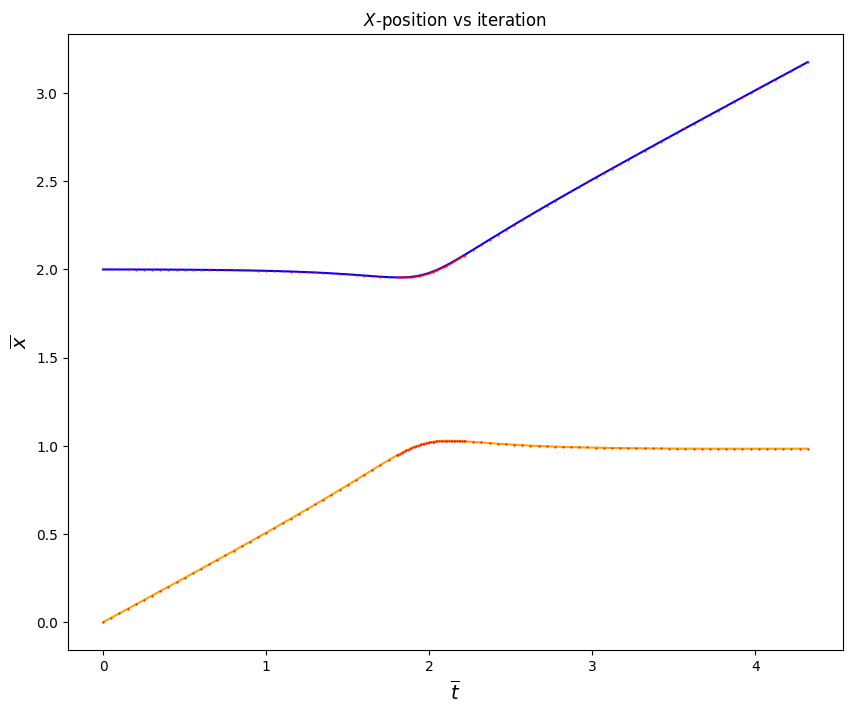

In [363]:
X1 = s[0][:,0]
X2 = s[0][:,1]

plt.figure(figsize=(10,8))
plt.title(r'$X$-position vs iteration')
plt.ylabel(r'$\overline{x}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,X1,'-',color='orange') ;plt.plot(time,X1,'o',color='red', ms=0.5)
plt.plot(time,X2,'-b',ms=0.5)        ;plt.plot(time,X2,'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.show()

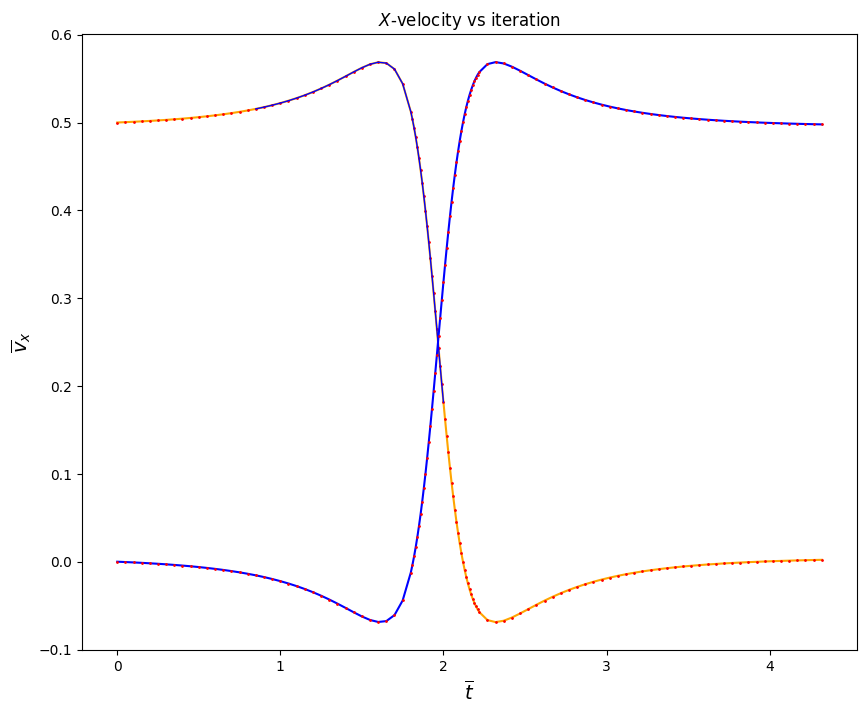

In [364]:
VX1 = s[2][:,0]
VX2 = s[2][:,1]

plt.figure(figsize=(10,8))
plt.title(r'$X$-velocity vs iteration')
plt.ylabel(r'$\overline{v}_x$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,VX1,'-',color='orange') ;plt.plot(time,VX1,'o',color='red', ms=1)
plt.plot(time,VX2,'-b',ms=0.5)        ;plt.plot(time,VX2,'o',color='red', ms=1)

plt.plot(time[17:57],VX1[17:57],'-',color='blue',lw=1)

#plt.ylim(-0.2,4.2)
plt.show()

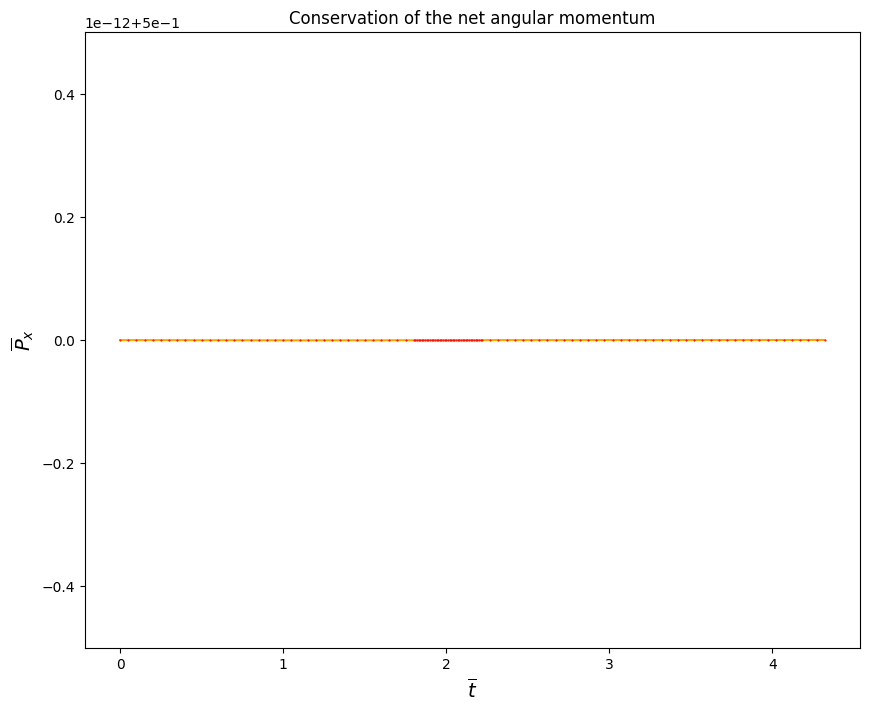

In [365]:
VX1 = s[2][:,0]
VX2 = s[2][:,1]

plt.figure(figsize=(10,8))
plt.title('Conservation of the net angular momentum')
plt.ylabel(r'$\overline{P}_x$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,VX1+VX2,'-',color='orange') ;plt.plot(time,VX1+VX2,'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.show()

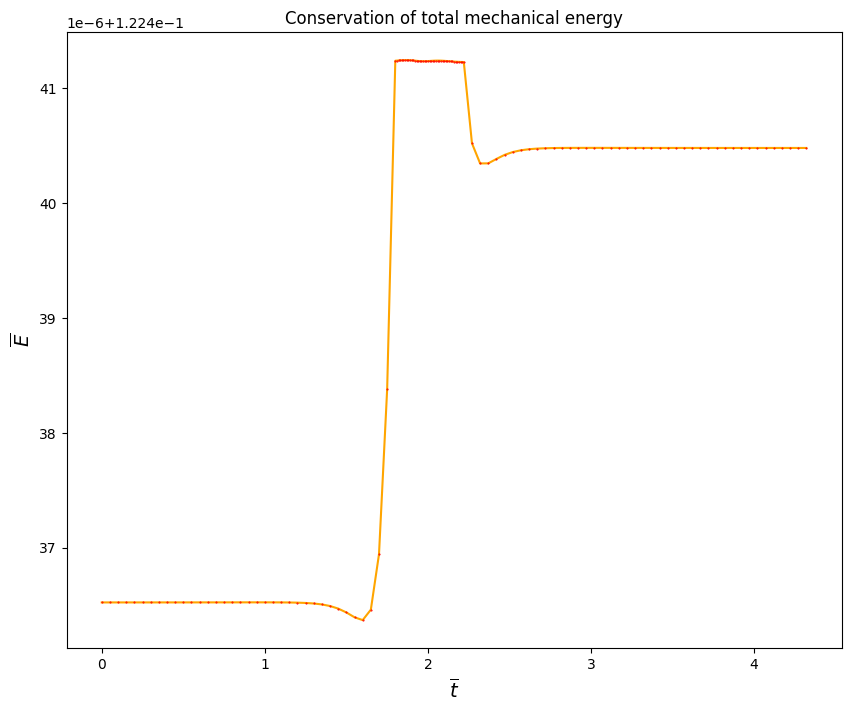

In [366]:
Em = sim.get_Energy(s)[2]

plt.figure(figsize=(10,8))
plt.title('Conservation of total mechanical energy')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,Em,'-',color='orange') ;plt.plot(time,Em,'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.show()

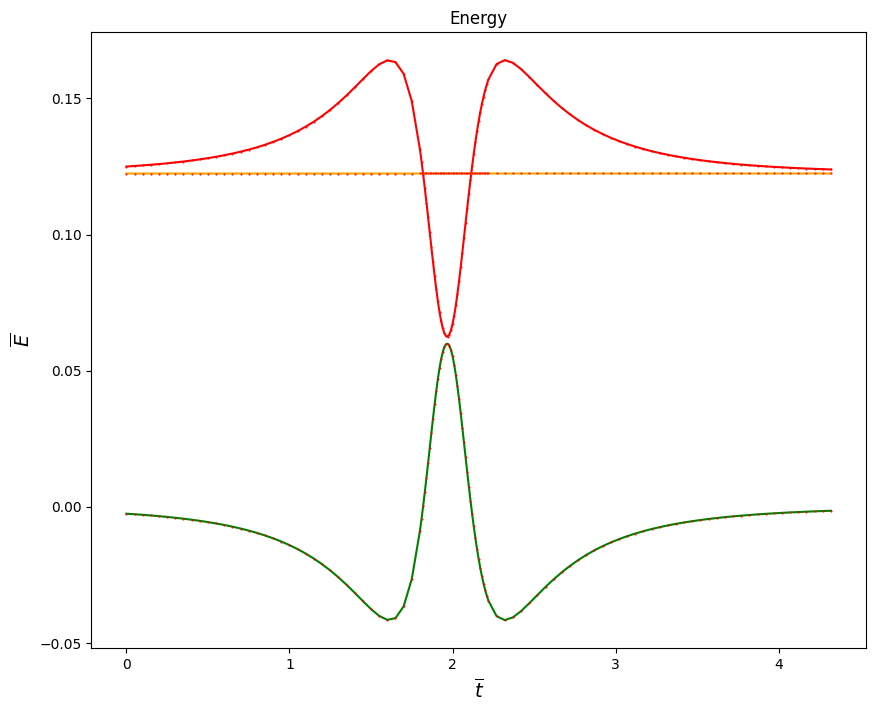

In [367]:
Ek, V, Em  = sim.get_Energy(s)

plt.figure(figsize=(10,8))
plt.title('Energy')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time, Ek,'-',color='red') ;plt.plot(time, Ek,'o',color='red', ms=0.5)
plt.plot(time, V,'-',color='green') ;plt.plot(time, V,'o',color='red', ms=0.5)
plt.plot(time, Em,'-',color='orange') ;plt.plot(time, Em,'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.show()

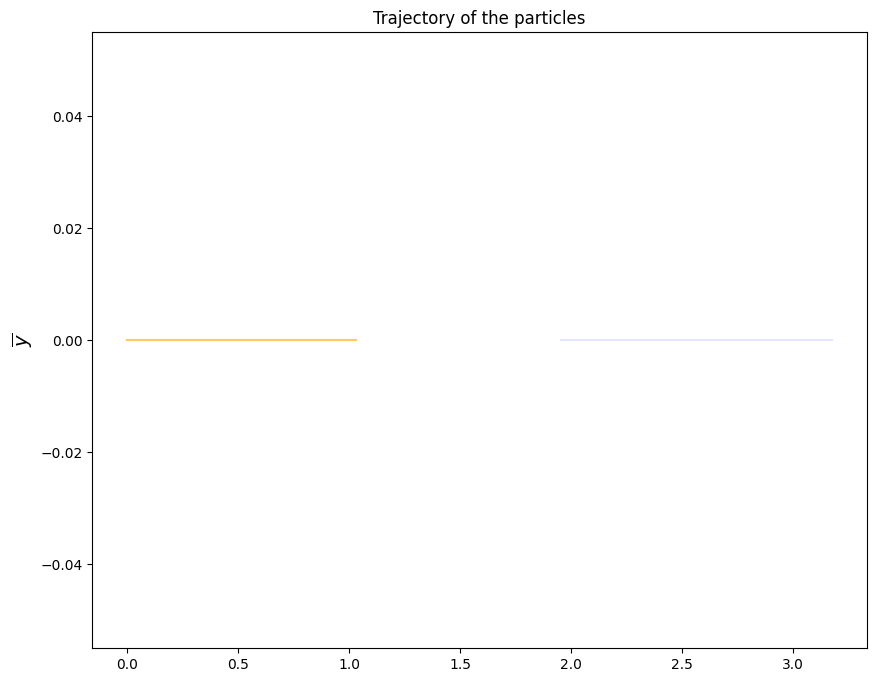

In [368]:
X1 = s[0][:,0]
X2 = s[0][:,1]
Y1 = s[1][:,0]
Y2 = s[1][:,1]

plt.figure(figsize=(10,8))
plt.title(r'Trajectory of the particles')
plt.ylabel(r'$\overline{x}$',fontsize=14)
plt.ylabel(r'$\overline{y}$',fontsize=14)
plt.plot(X1,Y1,'-',color='orange',alpha=0.6) #;plt.plot(X1,Y1, 'o',color='red', ms=0.5)
plt.plot(X2,Y2,'-b',ms=0.5,alpha=0.1)        #;plt.plot(X2,Y2, 'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.show()

In [369]:
X1 = s[0][:,0]; X2 = s[0][:,1]
Y1 = s[1][:,0]; Y2 = s[1][:,1]
R = np.sqrt((X1-X2)**2+(Y1-Y2)**2)

In [350]:
dX1 = X1[1:]-X1[0:-1]
v_num = dX1/h
VX1 = s[2][:,0]; VY1 = s[3][:,0]
VX2 = s[2][:,1]; VY2 = s[3][:,1]
V1 = np.sqrt(VX1**2+VY1**2)
V2 = np.sqrt(VX2**2+VY2**2)

In [360]:
CR = -(V1[-1]-V2[-1])/(V1[0]-V2[0]) #Coeficient of restitution
CR

0.9913914363569386

In [324]:
aux = V1[0:-1]-v_num
aux[17:57]

array([0.01732998, 0.38321778, 0.37538588, 0.36687581, 0.35767421,
       0.34777485, 0.33717987, 0.32590083, 0.31395964, 0.30138933,
       0.28823434, 0.27455064, 0.26040527, 0.24587545, 0.23104732,
       0.21601415, 0.20087421, 0.18572845, 0.17067796, 0.15582146,
       0.14125287, 0.12705925, 0.11331892, 0.10010014, 0.08746015,
       0.07544474, 0.06408821, 0.05341373, 0.04343401, 0.03415221,
       0.02556301, 0.01765381, 0.01040589, 0.00379563, 0.00500812,
       0.01296658, 0.02011354, 0.02649889, 0.03217294, 0.0371856 ])

In [325]:
aux

array([-1.24553982e-03, -1.36983683e-03, -1.50540900e-03, -1.65193914e-03,
       -1.80812351e-03, -1.97100212e-03, -2.13487581e-03, -2.28954996e-03,
       -2.41747842e-03, -2.48911169e-03, -2.45533851e-03, -2.23532815e-03,
       -1.69746706e-03, -6.31129973e-04,  1.28989435e-03,  4.53882847e-03,
        9.71251839e-03,  1.73299775e-02,  3.83217783e-01,  3.75385877e-01,
        3.66875811e-01,  3.57674207e-01,  3.47774852e-01,  3.37179871e-01,
        3.25900826e-01,  3.13959644e-01,  3.01389327e-01,  2.88234342e-01,
        2.74550644e-01,  2.60405266e-01,  2.45875450e-01,  2.31047323e-01,
        2.16014148e-01,  2.00874211e-01,  1.85728454e-01,  1.70677965e-01,
        1.55821455e-01,  1.41252872e-01,  1.27059251e-01,  1.13318924e-01,
        1.00100139e-01,  8.74601477e-02,  7.54447379e-02,  6.40882104e-02,
        5.34137334e-02,  4.34340142e-02,  3.41522118e-02,  2.55630150e-02,
        1.76538127e-02,  1.04058945e-02,  3.79562819e-03,  5.00811889e-03,
        1.29665795e-02,  